# Data Literacy Project – Analyzing the Similarity of Covid-19 Time Series Pattern
University of Tuebingen, Winter Term 2021/2022
#### Xuanhao Cao, Dorothee Sigg

In [50]:
import numpy as np
import pandas as pd
from datetime import datetime
#from iso3166 import countries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tslearn.clustering as tsc
from tslearn.utils import to_time_series_dataset
from tslearn.metrics import dtw, soft_dtw, dtw_path
from math import floor, ceil, prod
from tslearn.barycenters import \
    euclidean_barycenter, \
    dtw_barycenter_averaging
import folium
import pycountry_convert as pc
import random
import io
from PIL import Image

In [10]:
# load covid data per country: weekly cases per million

url_wcpm = 'https://github.com/owid/covid-19-data/raw/master/public/data/jhu/weekly_cases_per_million.csv'
weekly_cases_full = pd.read_csv(url_wcpm)

# Inspect first few rows of the data
print('Number of rows (=days) in the dataframe: ', len(weekly_cases_full))
print('Number of columns (=countries) in the dataframe: ', len(weekly_cases_full.columns))
weekly_cases_full.head()

Number of rows (=days) in the dataframe:  746
Number of columns (=countries) in the dataframe:  230


,date,World,Afghanistan,Africa,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,...,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Wallis and Futuna,Yemen,Zambia,Zimbabwe
0,2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# only take data from omikrom wave 
# (WHO classified omicron as variant of concern from 26. November 2021 onwards)

weekly_cases_full = weekly_cases_full.set_index('date')
weekly_cases_full = weekly_cases_full['2021-11-26':]
dates = pd.to_datetime(weekly_cases_full.index)

In [12]:
# only take data from europe

def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

country_continent_dict = {}
for c in weekly_cases_full.columns: 
    try:
        country_continent_dict[c] = country_to_continent(c)
    except:
        country_continent_dict[c] = 'undefined'
    
europe_countries = [k for k, v in country_continent_dict.items() if v == 'Europe']

data_eu_raw = pd.DataFrame(weekly_cases_full[[c for c in weekly_cases_full.columns if c in europe_countries]])
print(data_eu_raw.shape)
print(data_eu_raw.columns.values)

(72, 45)
['Albania' 'Andorra' 'Austria' 'Belarus' 'Belgium'
 'Bosnia and Herzegovina' 'Bulgaria' 'Croatia' 'Czechia' 'Denmark'
 'Estonia' 'Finland' 'France' 'Germany' 'Gibraltar' 'Greece' 'Hungary'
 'Iceland' 'Ireland' 'Isle of Man' 'Italy' 'Latvia' 'Liechtenstein'
 'Lithuania' 'Luxembourg' 'Malta' 'Moldova' 'Monaco' 'Montenegro'
 'Netherlands' 'North Macedonia' 'Norway' 'Poland' 'Portugal' 'Romania'
 'Russia' 'San Marino' 'Serbia' 'Slovakia' 'Slovenia' 'Spain' 'Sweden'
 'Switzerland' 'Ukraine' 'United Kingdom']


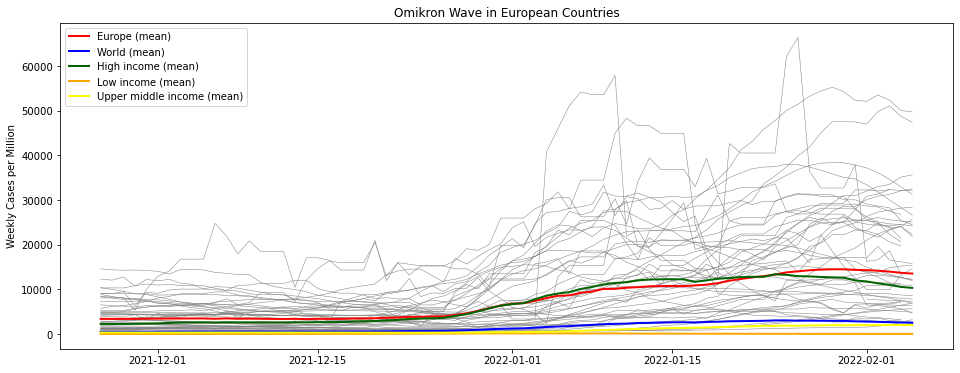

In [13]:
# make first plot of dataset
plt.figure(figsize=(16, 6))
plt.plot(dates, data_eu_raw, color='grey', linewidth=0.5)
plt.plot(dates, weekly_cases_full['2021-11-26':]['Europe'], color='red', linewidth=2, label='Europe (mean)')
plt.plot(dates, weekly_cases_full['2021-11-26':]['World'], color='blue', linewidth=2, label='World (mean)')
plt.plot(dates, weekly_cases_full['2021-11-26':]['High income'], color='darkgreen', linewidth=2, label='High income (mean)')
plt.plot(dates, weekly_cases_full['2021-11-26':]['Low income'], color='orange', linewidth=2, label='Low income (mean)')
plt.plot(dates, weekly_cases_full['2021-11-26':]['Upper middle income'], color='yellow', linewidth=2, label='Upper middle income (mean)')
plt.legend(loc='upper left')
plt.title('Omikron Wave in European Countries')
plt.ylabel('Weekly Cases per Million')
plt.show()

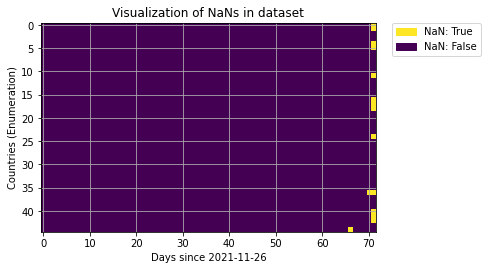

There are 15 NaNs.


In [14]:
# preprocess: NaNs

# find out where NaNs are located
is_nan = data_eu_raw.isna()

plt.figure(figsize=(6,10))
im = plt.imshow(is_nan.T, interpolation='none')
colors = [ im.cmap(im.norm(b)) for b in [True, False]]
patches = [ mpatches.Patch(color=colors[i], label="NaN: {l}".format(l=[True, False][i]) ) for i in range(2) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.grid(True)
plt.title('Visualization of NaNs in dataset')
plt.xlabel(f'Days since {dates[0].date()}')
plt.ylabel('Countries (Enumeration)')
plt.show()

print('There are', is_nan.sum().sum(), 'NaNs.')

In [15]:
# since the NaNs are not at the beginning of end of dataset, we can interpolate them
data_eu = data_eu_raw.apply(func=lambda x: x.interpolate())
print('Interpolating: Removed', data_eu_raw.isna().sum().sum()-data_eu.isna().sum().sum(), 'NaN values.')

print('There are', data_eu.isna().sum().sum(), 'NaNs left.')

# since the data changes everyday it might be the case that NaNs appear (at the end of the dataset)
# for this case we replace them with the value from the previous day

if data_eu.isna().sum().sum() != 0:
    data_eu = data_eu.fillna(method='ffill')
    print('Forwardfilling: There are', data_eu.isna().sum().sum(), 'NaNs left.')

Interpolating: Removed 15 NaN values.
There are 0 NaNs left.


#### Look at similarities between countries 

In [22]:
similarities_dtw = pd.DataFrame(index=data_eu.columns.values, columns=data_eu.columns.values)
for c1 in data_eu.columns.values:
    for c2 in data_eu.columns.values:
        d = dtw(data_eu[c1], data_eu[c2])
        similarities_dtw[c1].loc[c2] = int(d)
        
similarities_euc = pd.DataFrame(index=data_eu.columns.values, columns=data_eu.columns.values)

for c1 in data_eu.columns.values:
    for c2 in data_eu.columns.values:
        d = np.linalg.norm(data_eu[c1]-data_eu[c2])
        similarities_euc[c1].loc[c2] = int(d)

nearest_countries_df = pd.DataFrame(index=data_eu.columns.values, columns=['dtw_nearest', 'dtw_value',
                                                                           'euc_nearest', 'euc_value'])

for c in similarities_dtw:
    s_dtw = similarities_dtw[c].drop(c)
    s_euc = similarities_euc[c].drop(c)
    nearest_countries_df.loc[c] = pd.Series({'dtw_nearest': s_dtw.index[s_dtw.values.argmin()], 
                                             'dtw_value': s_dtw[s_dtw.values.argmin()],
                                             'euc_nearest': s_euc.index[s_euc.values.argmin()], 
                                             'euc_value': s_euc[s_euc.values.argmin()]})

nearest_countries_df['diff_value'] = nearest_countries_df['dtw_value'] - nearest_countries_df['euc_value']
nearest_countries_df

,dtw_nearest,dtw_value,euc_nearest,euc_value,diff_value
Albania,Bosnia and Herzegovina,2021,Bosnia and Herzegovina,4248,-2227
Andorra,San Marino,64724,San Marino,93950,-29226
Austria,Czechia,8960,Lithuania,20403,-11443
Belarus,Ukraine,5868,Ukraine,10251,-4383
Belgium,Gibraltar,12642,Liechtenstein,33742,-21100
Bosnia and Herzegovina,Albania,2021,Albania,4248,-2227
Bulgaria,Moldova,7180,North Macedonia,14188,-7008
Croatia,Germany,13621,Serbia,32777,-19156
Czechia,Slovakia,8379,Slovakia,25087,-16708
Denmark,Slovenia,14017,France,75085,-61068


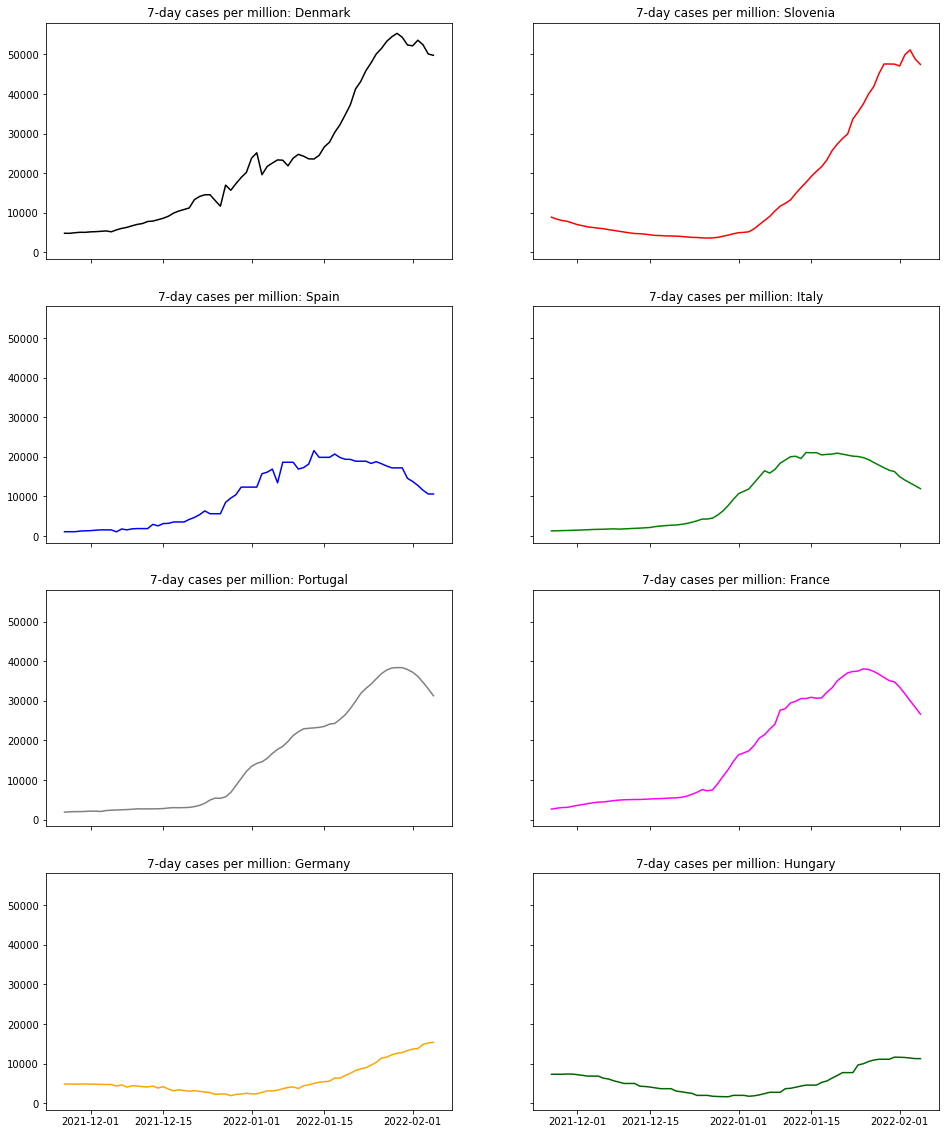

In [23]:
# lets pick a few countries and look at the plots
countries = ['Denmark', 'Slovenia', 'Spain', 'Italy', 'Portugal', 'France', 'Germany', 'Hungary']
colors = ['black', 'red', 'blue', 'green', 'grey', 'magenta', 'orange', 'darkgreen']

fig, axs = plt.subplots(ceil(len(countries)/2), 2, sharex=True, sharey=True, figsize=(16, ceil(len(countries)/2)*5))

def axs_pos(x):
    fst = floor(x/2)
    if x % 2 == 0:
        snd = 0
    else:
        snd = 1
    return (fst, snd)

for i in range(len(countries)):
    axs[axs_pos(i)].plot(dates, data_eu[countries[i]], color=colors[i])
    axs[axs_pos(i)].set_title(f'7-day cases per million: {countries[i]}')

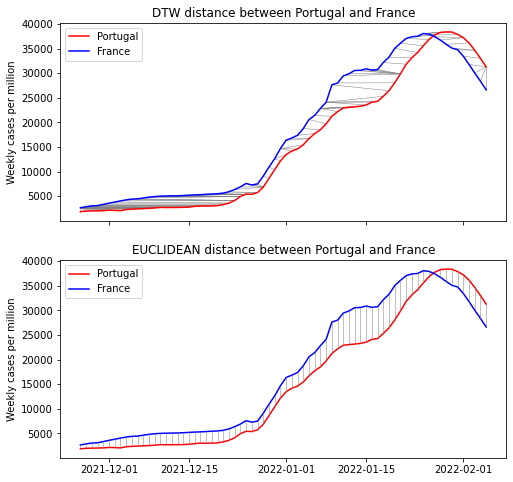

In [25]:
# compare: (best) DTW distances and (best) EUCLIDEAN distances between Portugal/France

name_1 = 'Portugal'
name_2 = 'France'
name_3 = 'France'
country_1 = data_eu[name_1]
country_2 = data_eu[name_2]
country_3 = data_eu[name_3]
# DTW distance
path_1, dist_1 = dtw_path(country_1, country_2)

fig, axs = plt.subplots(2, 1, sharey=True, sharex=True, figsize=(8, 8))
# DTW plot
for positions in path_1:
    axs[0].plot([dates[positions[0]], dates[positions[1]]],
                [country_1.iloc[positions[0]], country_2.iloc[positions[1]]], color='grey', linewidth=0.5)
axs[0].plot(dates, country_1, "r-", label=name_1, linewidth=1.5)
axs[0].plot(dates, country_2, "b-", label=name_2, linewidth=1.5)
axs[0].legend(loc='upper left')
axs[0].set_ylabel('Weekly cases per million')
axs[0].set_title(f"DTW distance between {name_1} and {name_2}")

# EUCLIDEAN plot
axs[1].plot(dates, country_1, "r-", label=name_1)
axs[1].plot(dates, country_3, "b-", label=name_3)

for positions in range(len(dates)):
    axs[1].plot([dates[positions], dates[positions]],
                [country_1.iloc[positions], country_3.iloc[positions]], color='grey', linewidth=0.5)
axs[1].set_ylabel('Weekly cases per million')
axs[1].set_title(f"EUCLIDEAN distance between {name_1} and {name_3}")
axs[1].legend(loc='upper left')


#plt.show()

plt.savefig('DTW_EUC_comparison.jpeg')

#### Using TimeSeriesKMeans algorithm

In [39]:
# iterating over hyperparameter (n_clusters)
# using silhouette score to evaluate clustering
random.seed(40)

dataset = data_eu.T

ks = range(2, 20, 1)
m = 'dtw'
scs = []
for k in ks:
    print('Using k =', k, m)
    model = tsc.TimeSeriesKMeans(n_clusters=k, metric=m, max_iter=100)
    labels = model.fit_predict(dataset)
    # print(labels)
    sc = tsc.silhouette_score(dataset, labels, metric=m)
    print('silhouette score:', round(sc, 4))
    scs.append(sc)

best_sc = max(scs)
best_k = ks[scs.index(best_sc)]
print(f'Best clustering: silhouette score = {best_sc}, using k = {best_k}')

Using k = 2 dtw
silhouette score: 0.4681
Using k = 3 dtw
silhouette score: 0.4963
Using k = 4 dtw
silhouette score: 0.5099
Using k = 5 dtw
silhouette score: 0.4706
Using k = 6 dtw
silhouette score: 0.5006
Using k = 7 dtw
silhouette score: 0.3612
Using k = 8 dtw
silhouette score: 0.3767
Using k = 9 dtw
silhouette score: 0.3612
Using k = 10 dtw
silhouette score: 0.3731
Using k = 11 dtw
silhouette score: 0.3746
Using k = 12 dtw
silhouette score: 0.3613
Using k = 13 dtw
silhouette score: 0.3519
Using k = 14 dtw
silhouette score: 0.3162
Using k = 15 dtw
silhouette score: 0.3055
Using k = 16 dtw
silhouette score: 0.3228
Using k = 17 dtw
silhouette score: 0.2723
Using k = 18 dtw
silhouette score: 0.252
Using k = 19 dtw
silhouette score: 0.2748
Best clustering: silhouette score = 0.509902076554507, using k = 4


In [40]:
# using time series k-means algorithm
n_clusters = best_k
metric = 'dtw'

model = tsc.TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, max_iter=100)
labels = model.fit_predict(dataset)
print(labels)
print(len(labels))


[1 0 2 1 2 1 1 1 2 0 0 1 0 1 2 3 1 2 3 3 3 2 2 2 2 1 1 3 3 2 1 2 1 0 1 1 0
 1 2 0 3 2 2 1 3]
45


In [41]:
# compute silhouette score (-1 for incorrect clustering and +1 for highly dense clustering)
sc = tsc.silhouette_score(dataset, labels, metric=metric)
print('silhouette score:', sc)

silhouette score: 0.44132925991166483


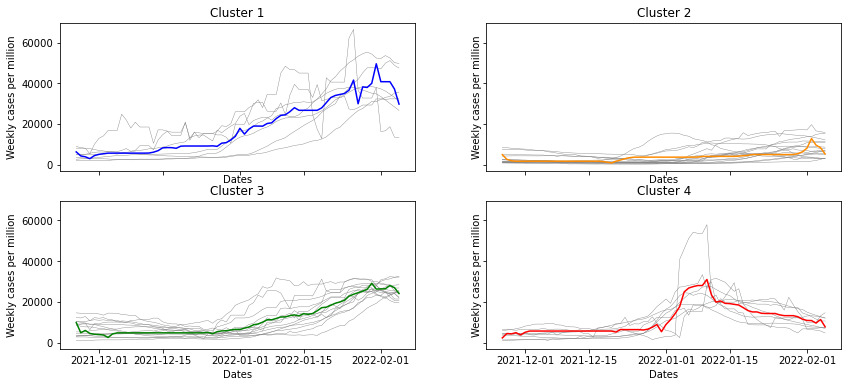

In [92]:
# plot clusterings
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(14, 6))
centroids = []

locs = {0: (0, 0), 1: (0, 1), 2: (1, 0), 3: (1,1)}
cols = {0: 'blue', 1: 'darkorange', 2: 'green', 3: 'red'}

for c in range(n_clusters):
    b = [c==label for label in labels]
    axs[locs[c]].plot(dates, dataset.iloc[b].T, linewidth=0.4, label = dataset.index[b], color='grey')
    axs[locs[c]].set_title(f'Cluster {c+1}')
    #axs[c].legend(loc='upper left')
    centroid = dtw_barycenter_averaging(dataset.iloc[b]) #euclidean_barycenter(dataset.iloc[b])
    centroids.append(centroid)
    axs[locs[c]].plot(dates, centroid, color=cols[c])
    axs[locs[c]].set_ylabel('Weekly cases per million')
    axs[locs[c]].set_xlabel('Dates')
plt.savefig('clusters.jpeg')

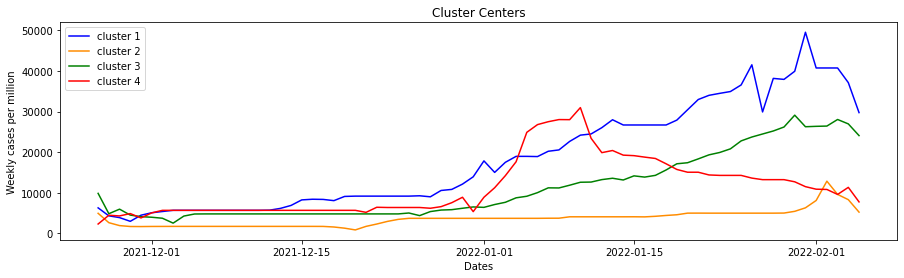

In [91]:
plt.figure(figsize=(15,4))
for i in range(len(centroids)): 
    plt.plot(dates, centroids[i], label=f'cluster {i+1}', color=cols[i])
    plt.legend()
plt.title('Cluster Centers')
plt.ylabel('Weekly cases per million')
plt.xlabel('Dates')

plt.savefig('clustermeans.jpeg')

In [48]:
country_cluster = pd.DataFrame(zip(dataset.T.columns, labels), 
                               columns=["Country","Cluster"]).sort_values(by="Cluster").set_index("Country")
#country_cluster = country_cluster['Cluster'].replace([0, 1, 2, 3, 4], [0, 1, 3, 2, 4])
#print(country_cluster[country_cluster['Cluster'] == 1])

for i in range(best_k):
    print(f'Countries for cluster nr. {i}')
    ls = country_cluster[country_cluster['Cluster'] == i].index.values
    print(ls, '\n')

Countries for cluster nr. 0
['Andorra' 'Portugal' 'Slovenia' 'Denmark' 'Estonia' 'France' 'San Marino'] 

Countries for cluster nr. 1
['Albania' 'Malta' 'North Macedonia' 'Ukraine' 'Poland' 'Romania' 'Russia'
 'Hungary' 'Germany' 'Moldova' 'Finland' 'Croatia' 'Bulgaria'
 'Bosnia and Herzegovina' 'Belarus' 'Serbia'] 

Countries for cluster nr. 2
['Slovakia' 'Sweden' 'Norway' 'Switzerland' 'Netherlands' 'Liechtenstein'
 'Luxembourg' 'Lithuania' 'Latvia' 'Iceland' 'Gibraltar' 'Czechia'
 'Belgium' 'Austria'] 

Countries for cluster nr. 3
['Monaco' 'Italy' 'Isle of Man' 'Ireland' 'Greece' 'Spain' 'Montenegro'
 'United Kingdom'] 



In [49]:
data_for_map = country_cluster.reset_index().replace(['Czechia','Serbia'], 
                                                     ['Czech Republic','Republic of Serbia'])

print(data_for_map.head())

    Country  Cluster
0   Andorra        0
1  Portugal        0
2  Slovenia        0
3   Denmark        0
4   Estonia        0


In [85]:
# Setup a folium map at a high-level zoom
url3 = 'world-countries.json'
m = folium.Map(zoom_start=3.5, location=[53,19]) #location=[100, 0],

# choropleth maps bind Pandas Data Frames and json geometries.
#This allows us to quickly visualize data combinations
m.choropleth(geo_data=url3, data=data_for_map,
             columns=['Country', 'Cluster'],
             key_on='feature.properties.name',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.8,
             nan_fill_color='White',
             bins=n_clusters,
#              legend_name=hist_indicator
              )
m
